In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn import datasets
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

#logistic regression
from sklearn.linear_model import LogisticRegression

#Decision Tree
from sklearn.tree import DecisionTreeClassifier

#KNN
from sklearn.neighbors import KNeighborsClassifier

#Gaussian
from sklearn.naive_bayes import GaussianNB

#Random Forest
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Read Datasets
df = pd.read_csv("fifa20.csv")
pd.set_option('display.max_columns',None)
df.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,"Beat Offside Trap, Argues with Officials, Earl...",88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,"Long Throw-in, Selfish, Argues with Officials,...",84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Injury Free, Selfish, Early C...",87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,91,93,77500000,125000,GK,Right,3,3,1,Medium/Medium,Normal,Yes,164700000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,89.0,52.0,90.0,"Flair, Acrobatic Clearance",13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,

In [3]:
# df[df['team_position'] == 'SUB']

In [39]:
df_p = df.copy()
df.shape

(18278, 104)

## Data Exploration and Data Preparation

### Checking for Class Value
SUB dan RES bukanlah posisi pemain yang berada di dalam lapangan. Sehingga baris yang memiliki posisi SUB dan RES akan dihapus. Ini juga berguna untuk menyeimbangkan jumlah data pada setiap class agar tidak terlalu jauh.

In [40]:
df.team_position.unique()
# df_p[df_p['team_position'].isnull()]
# df_p['team_position'][327] = df_p['player_positions']

array(['RW', 'LW', 'CAM', 'GK', 'RCM', 'LCB', 'ST', 'CDM', 'LDM', 'RM',
       'RCB', 'LCM', 'LM', 'CF', 'SUB', 'LB', 'LS', 'RB', 'RDM', 'RES',
       'RAM', 'RS', 'RF', 'CM', 'CB', 'LF', 'LAM', nan, 'RWB', 'LWB'],
      dtype=object)

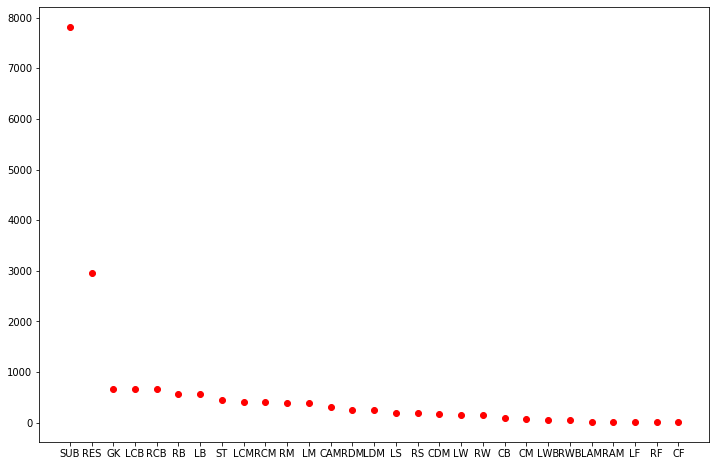

In [41]:
plt.figure(figsize=(12,8))
plt.plot(df_p.team_position.value_counts(), 'ro')

In [42]:
df_p = df_p.drop(df_p[df_p['team_position'] == 'SUB'].index)
df_p = df_p.drop(df_p[df_p['team_position'] == 'RES'].index)

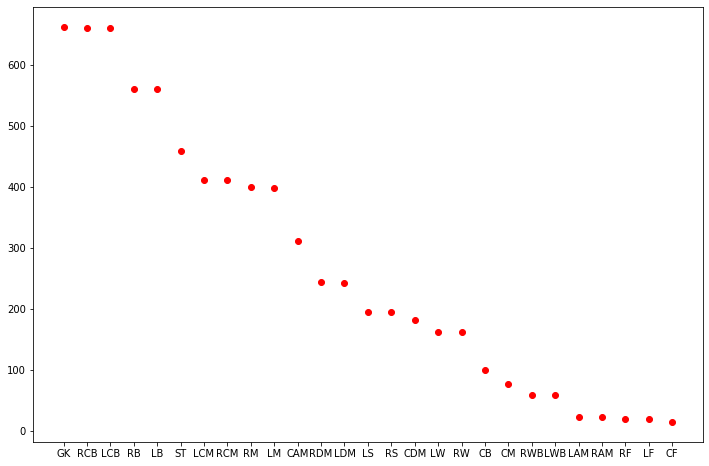

In [43]:
plt.figure(figsize=(12,8))
plt.plot(df_p.team_position.value_counts(), 'ro')

### Checking for Null Value
Ada 2 cara yang digunakan dalam penanganan nilai kosong :
 1. Penghapusan baris data jika pada suatu kolom memiliki nilai kosong yang tidak terlalu banyak.
 2. Pengubahan value jika suatu kolom memiliki nilai kosong yang banyak. Pengubahan ini dilakukan dengan asumsi yang dibuat sendiri. Dalam kasus ini, asumsi yang dibuat adalah mengubahnya menjadi 0 atau '0' karena data tersebut merupakan skill point dari pemain. Sehingga dapat diartikan bahwa pemain yang memiliki skill value NULL sama saja dengan tidak memiliki skill tersebut.

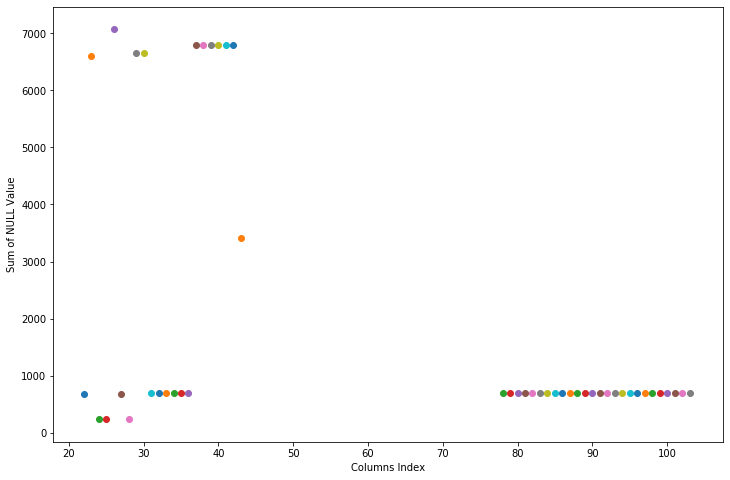

In [44]:
plt.figure(figsize=(12,8))
plt.xlabel("Columns Index")
plt.ylabel("Sum of NULL Value")
for col in df_p.columns:
    if df_p[col].isnull().sum() > 0:
#         print(col, ' = ', df_p[col].isnull().sum())
        plt.scatter(df_p.columns.get_loc(col), df_p[col].isnull().sum())

In [45]:
df_p.shape

(7500, 104)

In [46]:
for col in df_p.columns:
    if df_p[col].isnull().sum() > 0:
        print(col, ' = ', df_p[col].isnull().sum())

release_clause_eur  =  679
player_tags  =  6595
team_position  =  240
team_jersey_number  =  240
loaned_from  =  7066
joined  =  674
contract_valid_until  =  240
nation_position  =  6659
nation_jersey_number  =  6659
pace  =  702
shooting  =  702
passing  =  702
dribbling  =  702
defending  =  702
physic  =  702
gk_diving  =  6798
gk_handling  =  6798
gk_kicking  =  6798
gk_reflexes  =  6798
gk_speed  =  6798
gk_positioning  =  6798
player_traits  =  3415
ls  =  702
st  =  702
rs  =  702
lw  =  702
lf  =  702
cf  =  702
rf  =  702
rw  =  702
lam  =  702
cam  =  702
ram  =  702
lm  =  702
lcm  =  702
cm  =  702
rcm  =  702
rm  =  702
lwb  =  702
ldm  =  702
cdm  =  702
rdm  =  702
rwb  =  702
lb  =  702
lcb  =  702
cb  =  702
rcb  =  702
rb  =  702


In [47]:
null_col = [
    'team_position',
]
df_p = df_p.dropna(subset=null_col)

for col in df_p.columns:
    if df_p[col].isnull().sum() > 0:
        print(col, ' = ', df_p[col].isnull().sum())

release_clause_eur  =  439
player_tags  =  6378
loaned_from  =  6826
joined  =  434
nation_position  =  6659
nation_jersey_number  =  6659
pace  =  662
shooting  =  662
passing  =  662
dribbling  =  662
defending  =  662
physic  =  662
gk_diving  =  6598
gk_handling  =  6598
gk_kicking  =  6598
gk_reflexes  =  6598
gk_speed  =  6598
gk_positioning  =  6598
player_traits  =  3291
ls  =  662
st  =  662
rs  =  662
lw  =  662
lf  =  662
cf  =  662
rf  =  662
rw  =  662
lam  =  662
cam  =  662
ram  =  662
lm  =  662
lcm  =  662
cm  =  662
rcm  =  662
rm  =  662
lwb  =  662
ldm  =  662
cdm  =  662
rdm  =  662
rwb  =  662
lb  =  662
lcb  =  662
cb  =  662
rcb  =  662
rb  =  662


In [48]:
#Replace Null Value

coloumns = [
    'dribbling',
    'pace',
    'shooting',
    'passing',
    'defending',
    'physic',
    'gk_diving',
    'gk_handling',
    'gk_kicking',
    'gk_reflexes',
    'gk_speed',
    'gk_positioning',
]

str_columns = [
    'ls',
    'st',
    'rs',
    'lw',
    'lf',
    'cf',
    'rf',
    'rw',
    'lam',
    'cam',
    'ram',
    'lm',
    'lcm',
    'cm',
    'rcm',
    'rm',
    'lwb',
    'ldm',
    'cdm',
    'rdm',
    'rwb',
    'lb',
    'lcb',
    'cb',
    'rcb',
    'rb'
]

for col in coloumns:
    df_p.loc[df_p[col].isnull(), col] = 0
    
for col in str_columns:
    df_p.loc[df_p[col].isnull(), col] = '0'
    
for col in df_p.columns:
    if df_p[col].isnull().sum() > 0:
        print(col, ' = ', df_p[col].isnull().sum())

release_clause_eur  =  439
player_tags  =  6378
loaned_from  =  6826
joined  =  434
nation_position  =  6659
nation_jersey_number  =  6659
player_traits  =  3291


### Feature Selection
Melakukan penghapusan terhadap fitur yang dirasa tidak perlu dan tidak memiliki hubungan dengan Posisi Team.

In [49]:
# delete feature

coloumns = [
    'age',
    'value_eur',
    'wage_eur',
    'international_reputation',
    'dob',
    'sofifa_id',
    'player_url',
    'long_name',
    'nationality',
    'club',
    'player_positions',
    'body_type',
    'real_face',
    'team_jersey_number',
    'contract_valid_until',
    'release_clause_eur',
    'player_tags',
    'loaned_from',
    'joined',
    'nation_position',
    'nation_jersey_number',
    'player_traits',
    'ls',
    'st',
    'rs',
    'lw',
    'lf',
    'cf',
    'rf',
    'rw',
    'lam',
    'cam',
    'ram',
    'lm',
    'lcm',
    'cm',
    'rcm',
    'rm',
    'lwb',
    'ldm',
    'cdm',
    'rdm',
    'rwb',
    'lb',
    'lcb',
    'cb',
    'rcb',
    'rb',
]

for col in coloumns:
    df_p = df_p.drop(col, axis=1)

for col in df_p.columns:
    if df_p[col].isnull().sum() > 0:
        print(col, ' = ', df_p[col].isnull().sum())

### Adding new Feature
Fitur tambahan ini akan digunakan sebagai alat bantu dalam klasifikasi posisi, serta mengurangi jumlah fitur yang digunakan dengan cara mengelompokan fitur-fitur yang sejenis seperti GK_Skills, Attack_Skills, dan Defend_Skills.

In [50]:
#make new Feature

#GK Feature
gk_skills = df_p['gk_diving'] + df_p['gk_handling'] + df_p['gk_kicking'] + df_p['gk_reflexes'] + df_p['gk_speed'] + df_p['gk_positioning']
df_p['gk_skills'] = gk_skills

#Delete GK
gk_Columns = [
    'gk_diving',
    'gk_handling',
    'gk_kicking',
    'gk_reflexes',
    'gk_speed',
    'gk_positioning',
    'goalkeeping_diving',
    'goalkeeping_handling',
    'goalkeeping_kicking',
    'goalkeeping_reflexes',
    'goalkeeping_positioning',
]

for col in gk_Columns:
    df_p = df_p.drop(col, axis=1)

In [51]:
#Attack Feature
att_skills = df_p['attacking_crossing'] + df_p['attacking_finishing'] + df_p['attacking_heading_accuracy'] + df_p['attacking_short_passing'] + df_p['attacking_volleys']
df_p['att_skills'] = att_skills

#Delete Att
att_Columns = [
    'attacking_crossing',
    'attacking_finishing',
    'attacking_heading_accuracy',
    'attacking_short_passing',
    'attacking_volleys'
]

for col in att_Columns:
    df_p = df_p.drop(col, axis=1)

In [52]:
#Defending Feature
def_skills = df_p['defending_marking'] + df_p['defending_standing_tackle'] + df_p['defending_sliding_tackle']
df_p['def_skills'] = def_skills

#Delete Def
def_Columns = [
    'defending_marking',
    'defending_standing_tackle',
    'defending_sliding_tackle',
]

for col in def_Columns:
    df_p = df_p.drop(col, axis=1)

In [53]:
df_p['team_position'].unique()

array(['RW', 'LW', 'CAM', 'GK', 'RCM', 'LCB', 'ST', 'CDM', 'LDM', 'RM',
       'RCB', 'LCM', 'LM', 'CF', 'LB', 'LS', 'RB', 'RDM', 'RAM', 'RS',
       'RF', 'CM', 'CB', 'LF', 'LAM', 'RWB', 'LWB'], dtype=object)

In [54]:
#help class
df_p['group_position'] = df_p['team_position'].copy()

df_p.loc[df_p['group_position'] == "RF", 'group_position'] = "Forward"
df_p.loc[df_p['group_position'] == "LF", 'group_position'] = "Forward"
df_p.loc[df_p['group_position'] == "CF", 'group_position'] = "Forward"
df_p.loc[df_p['group_position'] == "LS", 'group_position'] = "Forward"
df_p.loc[df_p['group_position'] == "RS", 'group_position'] = "Forward"
df_p.loc[df_p['group_position'] == "ST", 'group_position'] = "Forward"

df_p.loc[df_p['group_position'] == "RW", 'group_position'] = "Midfielder"
df_p.loc[df_p['group_position'] == "LW", 'group_position'] = "Midfielder"
df_p.loc[df_p['group_position'] == "CAM", 'group_position'] = "Midfielder"
df_p.loc[df_p['group_position'] == "RAM", 'group_position'] = "Midfielder"
df_p.loc[df_p['group_position'] == "CDM", 'group_position'] = "Midfielder"
df_p.loc[df_p['group_position'] == "LDM", 'group_position'] = "Midfielder"
df_p.loc[df_p['group_position'] == "RDM", 'group_position'] = "Midfielder"
df_p.loc[df_p['group_position'] == "LAM", 'group_position'] = "Midfielder"
df_p.loc[df_p['group_position'] == "RM", 'group_position'] = "Midfielder"
df_p.loc[df_p['group_position'] == "LCM", 'group_position'] = "Midfielder"
df_p.loc[df_p['group_position'] == "RCM", 'group_position'] = "Midfielder"
df_p.loc[df_p['group_position'] == "LM", 'group_position'] = "Midfielder"
df_p.loc[df_p['group_position'] == "CM", 'group_position'] = "Midfielder"

df_p.loc[df_p['group_position'] == "LCB", 'group_position'] = "Back"
df_p.loc[df_p['group_position'] == "RCB", 'group_position'] = "Back"
df_p.loc[df_p['group_position'] == "LB", 'group_position'] = "Back"
df_p.loc[df_p['group_position'] == "RB", 'group_position'] = "Back"
df_p.loc[df_p['group_position'] == "CB", 'group_position'] = "Back"
df_p.loc[df_p['group_position'] == "RWB", 'group_position'] = "Back"
df_p.loc[df_p['group_position'] == "LWB", 'group_position'] = "Back"

df_p.loc[df_p['group_position'] == "GK", 'group_position'] = "GoalKeeping"


df_p['group_position'].unique()

array(['Midfielder', 'GoalKeeping', 'Back', 'Forward'], dtype=object)

In [55]:
df_p

,short_name,height_cm,weight_kg,overall,potential,preferred_foot,weak_foot,skill_moves,work_rate,team_position,pace,shooting,passing,dribbling,defending,physic,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,gk_skills,att_skills,def_skills,group_position
0,L. Messi,170,72,94,94,Left,4,4,Medium/Low,RW,87.0,92.0,92.0,96.0,39.0,66.0,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,0.0,433,96,Midfielder
1,Cristiano Ronaldo,187,83,93,93,Right,4,5,High/Low,LW,90.0,93.0,82.0,89.0,35.0,78.0,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,0.0,437,84,Midfielder
2,Neymar Jr,175,68,92,92,Right,5,5,High/Medium,CAM,91.0,85.0,87.0,95.0,32.0,58.0,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,0.0,410,82,Midfielder
3,J. Oblak,188,87,91,93,Right,3,1,Medium/Medium,GK,0.0,0.0,0.0,0.0,0.0,0.0,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,488.0,95,57,GoalKeeping
4,E. Hazard,175,74,91,91,Right,4,4,High/Medium,LW,91.0,83.0,86.0,94.0,35.0,66.0,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,0.0,398,83,Midfielder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18149,Yang Guoyuan,175,72,50,59,Right,2,2,Medium/Medium,RCM,63.0,41.0,52.0,53.0,41.0,59.0,51,44,35,53,51,60,65,63,50,74,49,79,37,75,38,40,24,41,53,48,55,0.0,220,134,Midfielder
18153,Yeljan Shinar,178,70,50,59,Right,3,2,Medium/Medium,RB,55.0,25.0,24.0,32.0,50.0,55.0,27,25,23,20,30,56,54,48,44,59,33,73,55,56,21,48,50,25,31,31,36,0.0,130,157,Back
18155,M. Kouogun,184,81,50,58,Right,2,2,Medium/High,RCB,52.0,25.0,29.0,28.0,50.0,60.0,22,25,28,22,26,51,53,45,41,48,35,66,57,66,18,46,49,25,34,32,40,0.0,154,154,Back
18182,J. White,188,72,49,69,Left,2,2,Medium/Medium,LB,66.0,24.0,29.0,48.0,48.0,54.0,53,30,32,29,35,69,64,63,54,42,20,59,62,50,23,54,45,39,32,35,37,0.0,148,151,Back


In [56]:
b_fit = df_p.team_position.unique()

### Checking for Categorical Data
Data yang bersifat kategorial akan diubah menjadi bentuk int agar bisa dilakukan proses perhitungan terhadap data tersebut.

In [57]:
le = LabelEncoder()
df_p['preferred_foot'] = le.fit_transform(df_p['preferred_foot'])
df_p['work_rate'] = le.fit_transform(df_p['work_rate'])
df_p['group_position'] = le.fit_transform(df_p['group_position'])
# df_p['team_position'] = le.fit_transform(df_p['team_position'])

In [58]:
a_fit = df_p.team_position.unique()

In [59]:
df_p

,short_name,height_cm,weight_kg,overall,potential,preferred_foot,weak_foot,skill_moves,work_rate,team_position,pace,shooting,passing,dribbling,defending,physic,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,gk_skills,att_skills,def_skills,group_position
0,L. Messi,170,72,94,94,0,4,4,7,RW,87.0,92.0,92.0,96.0,39.0,66.0,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,0.0,433,96,3
1,Cristiano Ronaldo,187,83,93,93,1,4,5,1,LW,90.0,93.0,82.0,89.0,35.0,78.0,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,0.0,437,84,3
2,Neymar Jr,175,68,92,92,1,5,5,2,CAM,91.0,85.0,87.0,95.0,32.0,58.0,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,0.0,410,82,3
3,J. Oblak,188,87,91,93,1,3,1,8,GK,0.0,0.0,0.0,0.0,0.0,0.0,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,488.0,95,57,2
4,E. Hazard,175,74,91,91,1,4,4,2,LW,91.0,83.0,86.0,94.0,35.0,66.0,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,0.0,398,83,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18149,Yang Guoyuan,175,72,50,59,1,2,2,8,RCM,63.0,41.0,52.0,53.0,41.0,59.0,51,44,35,53,51,60,65,63,50,74,49,79,37,75,38,40,24,41,53,48,55,0.0,220,134,3
18153,Yeljan Shinar,178,70,50,59,1,3,2,8,RB,55.0,25.0,24.0,32.0,50.0,55.0,27,25,23,20,30,56,54,48,44,59,33,73,55,56,21,48,50,25,31,31,36,0.0,130,157,0
18155,M. Kouogun,184,81,50,58,1,2,2,6,RCB,52.0,25.0,29.0,28.0,50.0,60.0,22,25,28,22,26,51,53,45,41,48,35,66,57,66,18,46,49,25,34,32,40,0.0,154,154,0
18182,J. White,188,72,49,69,0,2,2,8,LB,66.0,24.0,29.0,48.0,48.0,54.0,53,30,32,29,35,69,64,63,54,42,20,59,62,50,23,54,45,39,32,35,37,0.0,148,151,0


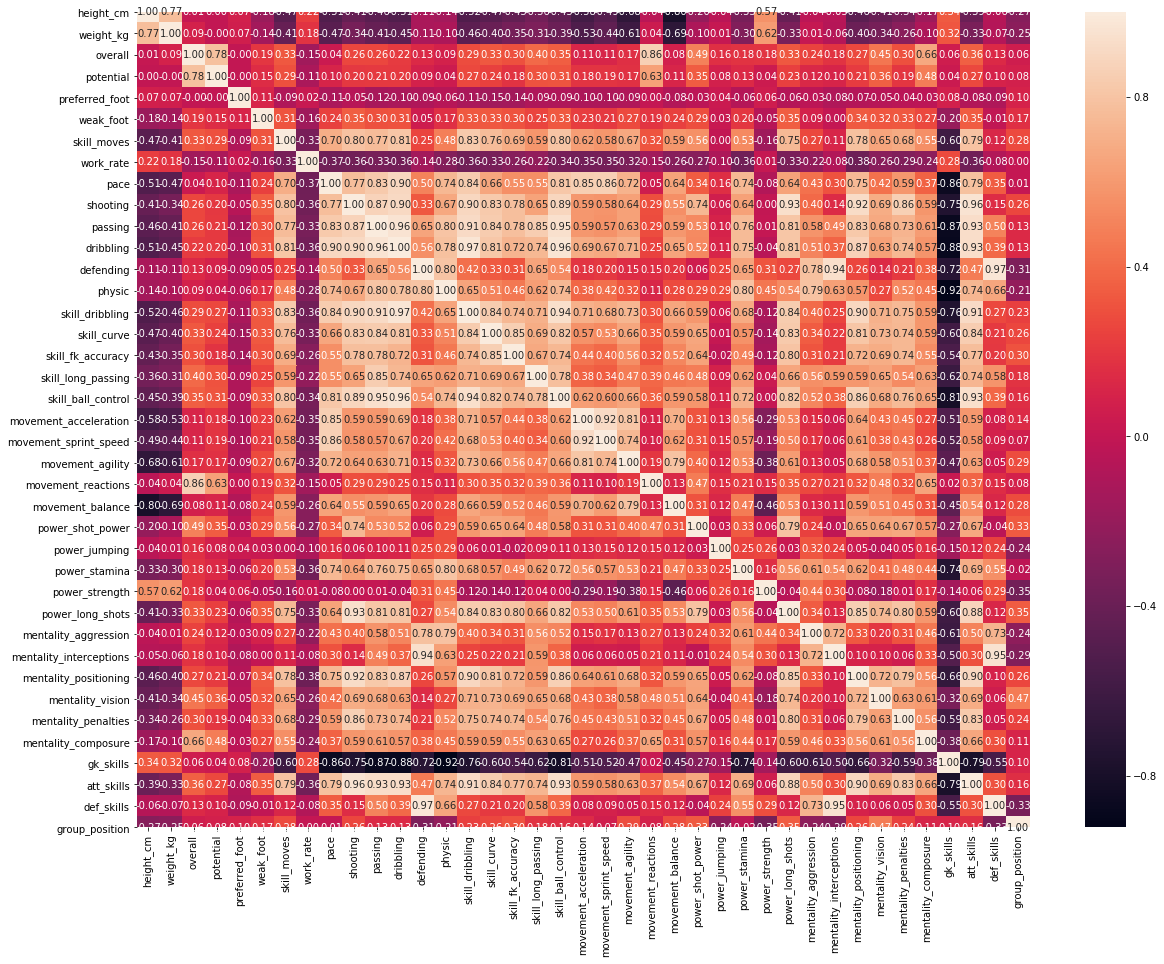

In [60]:
plt.figure(figsize=(20,15))
sns.heatmap(df_p.corr(), annot=True, fmt='.2f');

## Modeling

### Split Data
Dataset dibagi menjadi data training (75%) dan data test (25%)

In [61]:
X_le = df_p.copy()
X_le = X_le.drop('group_position', axis=1)
X_le = X_le.drop('team_position', axis=1)
# X_le = df_classification.drop('team_position', axis=1)
X_le = X_le.drop('short_name', axis=1)
y = df_p['group_position']
# y = df_p['team_position']
X_train, X_test, y_train, y_test = train_test_split(X_le, y, test_size=0.25, random_state=0)

In [62]:
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

In [63]:
nr = NearMiss()
X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train.ravel())

In [64]:
# Counter(y_train_miss)

In [65]:
# X_train_miss.shape

In [66]:
class Report:
    def __init__(self, X_test, y_test):
        self.X = X_test
        self.y = y_test
    
    def metrics(self, model):
        y_pred = model.predict(self.X)
        
        print('Precision score:\n')
        print(precision_score(self.y, y_pred, average='weighted'))
        
        print('Accuracy score:\n')
        print(accuracy_score(self.y, y_pred))
        
        print('\nConfusion Matrix:\n')
        print(confusion_matrix(self.y, y_pred))
        
        print('\nClassification Report:\n')
        print(classification_report(self.y, y_pred))
    

In [67]:
report = Report(X_test, y_test)

In [68]:
dt = DecisionTreeClassifier(max_depth=20).fit(X_train, y_train)
report.metrics(dt)

Precision score:

0.7943948147117454
Accuracy score:

0.7950413223140496

Confusion Matrix:

[[534   1   0 114]
 [  3 149   0  77]
 [  0   0 171   0]
 [117  60   0 589]]

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       649
           1       0.71      0.65      0.68       229
           2       1.00      1.00      1.00       171
           3       0.76      0.77      0.76       766

    accuracy                           0.80      1815
   macro avg       0.82      0.81      0.82      1815
weighted avg       0.79      0.80      0.79      1815



In [69]:
rf = RandomForestClassifier().fit(X_train, y_train)
report.metrics(rf)

Precision score:

0.8705145082544764
Accuracy score:

0.8710743801652893

Confusion Matrix:

[[593   0   0  56]
 [  0 163   0  66]
 [  0   0 171   0]
 [ 81  31   0 654]]

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       649
           1       0.84      0.71      0.77       229
           2       1.00      1.00      1.00       171
           3       0.84      0.85      0.85       766

    accuracy                           0.87      1815
   macro avg       0.89      0.87      0.88      1815
weighted avg       0.87      0.87      0.87      1815



In [70]:
knn = KNeighborsClassifier().fit(X_train, y_train)
report.metrics(knn)

Precision score:

0.8546679772825915
Accuracy score:

0.8545454545454545

Confusion Matrix:

[[566   0   0  83]
 [  0 164   0  65]
 [  0   0 171   0]
 [ 73  43   0 650]]

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       649
           1       0.79      0.72      0.75       229
           2       1.00      1.00      1.00       171
           3       0.81      0.85      0.83       766

    accuracy                           0.85      1815
   macro avg       0.87      0.86      0.87      1815
weighted avg       0.85      0.85      0.85      1815



In [71]:
log = LogisticRegression().fit(X_train, y_train)
report.metrics(log)

Precision score:

0.8725635534010433
Accuracy score:

0.8721763085399449

Confusion Matrix:

[[572   1   0  76]
 [  0 174   0  55]
 [  0   0 171   0]
 [ 70  30   0 666]]

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       649
           1       0.85      0.76      0.80       229
           2       1.00      1.00      1.00       171
           3       0.84      0.87      0.85       766

    accuracy                           0.87      1815
   macro avg       0.89      0.88      0.89      1815
weighted avg       0.87      0.87      0.87      1815



C:\Users\Immelman\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [72]:
y_pred = rf.predict(X_test)
hasil = [y_pred, y_test]
df_hasil = pd.DataFrame(hasil, index=['Predicted','Actual']) 
df_hasil

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

In [73]:
df_hasil.to_excel("hasil Classification.xlsx")